# **Vendor Performance Analysis**

### **Index**

1. **Business Problem & Objectives**
2. **Data Processing Methodology**

   2.1. Data Ingestion
   
   2.2. Data Overview
   
   2.3 Database Integration & Persistence Layer
   
4. **Feature Engineering & Modeling**
   
   3.1. Database Connection & Schema Verification

   3.1.1. Relational Integrity Check
   
   3.2. Advanced SQL Joins

   3.3. KPI Development
   
   3.4. Structural Implementation of the Analytical Data Warehouse
   
6. **Exploratory Data Analysis**
   
   4.1. Statistical Profiling and Distribution Analysis
   
   4.2. Data Filtering
   
   4.3. Distributions and Correlations
   
   4.3.1. Correlation Insights
   
   4.3.2. Vendors and Brands Analysis
   
   4.3.2.1. Brands Analysis
   
   4.3.2.2. Top 10 Vendors and Brands
   
   4.3.2.2.1 Top 10 vendors and brands in terms of Frequency
   
   4.3.2.2.2 Top 10 vendors and brands in terms of Sales
   
   4.3.2.2.3 Vendors Purchase Contribution
   
8. **Data Refinement for Insights**

   5.1. Evaluating the confidence intervals
   
   5.2. Hypotheses Testing

### **1. Business Problem & Objectives**

Effective inventory and sales management are critical for optimizing profitability in the retail and wholesale industry. Companies need to ensure that they are not incurring losses due to inefficient pricing, poor inventory turnover, or vendor dependency. The goal of this analysis is to:

- Identify underperforming brands that require promotional or pricing adjustments.
- Determine top vendors contributing to sales and gross profit.
- Analyze the impact of bulk purchasing on unit costs.
- Assess inventory turnover to reduce holding costs and improve efficiency.
- Investigate the profitability variance between high-performing and low-performing vendors.

### **2. Data Processing Methodology**
### 2.1. Data Ingestion

We import the dataset using pandas and preview the first five rows 
to understand the structure, column names, and overall format.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import scipy.stats as stats
from IPython.display import display, Markdown
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore",category = RuntimeWarning)

In [2]:
begin_inventory = pd.read_csv('begin_inventory.csv')
end_inventory = pd.read_csv('end_inventory.csv')
purchase_prices = pd.read_csv('purchase_prices.csv')
purchases = pd.read_csv('purchases.csv')
sales = pd.read_csv('sales.csv')
vendor_invoice = pd.read_csv('vendor_invoice.csv')

In [3]:
# 1. Create a dictionary to map custom names to your DataFrames
tables_dict = {
    "Beginning Inventory": begin_inventory,
    "Ending Inventory": end_inventory,
    "Purchase Prices": purchase_prices,
    "Purchases": purchases,
    "Sales": sales,
    "Vendor Invoice": vendor_invoice
}

# 2. Loop through keys and values
for name, table in tables_dict.items():
    display(Markdown(f"### **Table Name: {name}**")) # Shows the title
    display(table.head(5))                 # Shows the data
    display(table.shape)                 # Shows the number of rows and columns

### **Table Name: Beginning Inventory**

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2024-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2024-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2024-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2024-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2024-01-01


(206529, 9)

### **Table Name: Ending Inventory**

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2024-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2024-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2024-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2024-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2024-12-31


(224489, 9)

### **Table Name: Purchase Prices**

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


(12261, 9)

### **Table Name: Purchases**

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2023-12-24,2024-01-02,2024-01-09,2024-02-16,21.32,5,106.60,1


(2372474, 16)

### **Table Name: Sales**

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2024-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2024-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2024-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


(12825363, 14)

### **Table Name: Vendor Invoice**

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2024-01-04,8124,2023-12-21,2024-02-16,6,214.26,3.47,NaN
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,NaN
2,388,ATLANTIC IMPORTING COMPANY,2024-01-09,8169,2023-12-24,2024-02-16,5,106.60,4.61,NaN
3,480,BACARDI USA INC,2024-01-12,8106,2023-12-20,2024-02-05,10100,137483.78,2935.20,NaN
4,516,BANFI PRODUCTS CORP,2024-01-07,8170,2023-12-24,2024-02-12,1935,15527.25,429.20,NaN


(5543, 10)

### 2.2. Data Overview

- `Dataframe.info()` provides column data types and missing values.
- `Dataframe.describe()` gives statistical summaries for numerical columns.
This helps identify potential cleaning steps.

In [4]:
for name, table in tables_dict.items():
    display(Markdown(f"### **Table Name: {name}**"))
    display(table.info())
    display(table.describe())

### **Table Name: Beginning Inventory**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206529 entries, 0 to 206528
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InventoryId  206529 non-null  object 
 1   Store        206529 non-null  int64  
 2   City         206529 non-null  object 
 3   Brand        206529 non-null  int64  
 4   Description  206529 non-null  object 
 5   Size         206529 non-null  object 
 6   onHand       206529 non-null  int64  
 7   Price        206529 non-null  float64
 8   startDate    206529 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 14.2+ MB


None

,Store,Brand,onHand,Price
count,206529.000000,206529.000000,206529.000000,206529.000000
mean,42.122457,13761.482320,20.429455,22.253910
std,23.191393,13059.429355,31.467342,70.178964
min,1.000000,58.000000,0.000000,0.000000
25%,22.000000,3746.000000,7.000000,9.990000
50%,42.000000,8010.000000,12.000000,14.990000
75%,64.000000,22143.000000,21.000000,21.990000
max,79.000000,90090.000000,1251.000000,13999.900000


### **Table Name: Ending Inventory**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224489 entries, 0 to 224488
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InventoryId  224489 non-null  object 
 1   Store        224489 non-null  int64  
 2   City         223205 non-null  object 
 3   Brand        224489 non-null  int64  
 4   Description  224489 non-null  object 
 5   Size         224489 non-null  object 
 6   onHand       224489 non-null  int64  
 7   Price        224489 non-null  float64
 8   endDate      224489 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 15.4+ MB


None

,Store,Brand,onHand,Price
count,224489.000000,224489.000000,224489.000000,224489.000000
mean,43.505740,14356.370513,21.763988,23.585583
std,23.326415,13118.467851,37.233576,79.202775
min,1.000000,58.000000,0.000000,0.490000
25%,23.000000,3798.000000,7.000000,9.990000
50%,44.000000,8259.000000,12.000000,14.990000
75%,66.000000,23965.000000,22.000000,23.490000
max,81.000000,90631.000000,3676.000000,13999.900000


### **Table Name: Purchase Prices**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           12261 non-null  int64  
 1   Description     12260 non-null  object 
 2   Price           12261 non-null  float64
 3   Size            12260 non-null  object 
 4   Volume          12260 non-null  object 
 5   Classification  12261 non-null  int64  
 6   PurchasePrice   12261 non-null  float64
 7   VendorNumber    12261 non-null  int64  
 8   VendorName      12261 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 862.2+ KB


None

,Brand,Price,Classification,PurchasePrice,VendorNumber
count,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000
mean,17989.067123,38.640240,1.708996,26.488220,10814.861757
std,12528.503464,206.151172,0.454244,156.182948,19007.682322
min,58.000000,0.000000,1.000000,0.000000,2.000000
25%,5990.000000,10.990000,1.000000,6.890000,3960.000000
50%,18788.000000,15.990000,2.000000,10.650000,7153.000000
75%,25117.000000,29.990000,2.000000,20.130000,9552.000000
max,90631.000000,13999.900000,2.000000,11111.030000,173357.000000


### **Table Name: Purchases**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372474 entries, 0 to 2372473
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   InventoryId     object 
 1   Store           int64  
 2   Brand           int64  
 3   Description     object 
 4   Size            object 
 5   VendorNumber    int64  
 6   VendorName      object 
 7   PONumber        int64  
 8   PODate          object 
 9   ReceivingDate   object 
 10  InvoiceDate     object 
 11  PayDate         object 
 12  PurchasePrice   float64
 13  Quantity        int64  
 14  Dollars         float64
 15  Classification  int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 289.6+ MB


None

,Store,Brand,VendorNumber,PONumber,PurchasePrice,Quantity,Dollars,Classification
count,2.372474e+06,2.372474e+06,2.372474e+06,2.372474e+06,2.372474e+06,2.372474e+06,2.372474e+06,2.372474e+06
mean,4.465133e+01,1.241864e+04,6.886436e+03,1.104094e+04,1.205005e+01,1.415585e+01,1.356815e+02,1.443520e+00
std,2.351245e+01,1.255728e+04,8.066694e+03,1.565340e+03,1.794510e+01,2.344616e+01,2.816649e+02,4.967999e-01
min,1.000000e+00,5.800000e+01,2.000000e+00,8.106000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.500000e+01,3.639000e+03,3.252000e+03,9.761000e+03,6.120000e+00,6.000000e+00,4.926000e+01,1.000000e+00
50%,4.800000e+01,6.523000e+03,4.425000e+03,1.110300e+04,9.220000e+00,1.000000e+01,8.393000e+01,1.000000e+00
75%,6.700000e+01,1.887700e+04,9.552000e+03,1.239700e+04,1.449000e+01,1.200000e+01,1.405200e+02,2.000000e+00
max,8.100000e+01,9.063100e+04,2.013590e+05,1.366100e+04,5.681810e+03,3.816000e+03,5.017570e+04,2.000000e+00


### **Table Name: Sales**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12825363 entries, 0 to 12825362
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   InventoryId     object 
 1   Store           int64  
 2   Brand           int64  
 3   Description     object 
 4   Size            object 
 5   SalesQuantity   int64  
 6   SalesDollars    float64
 7   SalesPrice      float64
 8   SalesDate       object 
 9   Volume          float64
 10  Classification  int64  
 11  ExciseTax       float64
 12  VendorNo        int64  
 13  VendorName      object 
dtypes: float64(4), int64(5), object(5)
memory usage: 1.3+ GB


None

,Store,Brand,SalesQuantity,SalesDollars,SalesPrice,Volume,Classification,ExciseTax,VendorNo
count,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07,1.282536e+07
mean,4.389572e+01,1.215460e+04,2.566623e+00,3.524758e+01,1.569027e+01,9.394389e+02,1.413892e+00,1.479431e+00,7.125907e+03
std,2.353947e+01,1.236843e+04,4.551810e+00,8.835689e+01,1.512728e+01,6.993202e+02,4.925295e-01,4.736633e+00,8.742565e+03
min,1.000000e+00,5.800000e+01,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01,1.000000e+00,1.000000e-02,2.000000e+00
25%,2.300000e+01,3.663000e+03,1.000000e+00,1.099000e+01,8.990000e+00,7.500000e+02,1.000000e+00,2.100000e-01,3.252000e+03
50%,4.700000e+01,6.349000e+03,1.000000e+00,1.899000e+01,1.299000e+01,7.500000e+02,1.000000e+00,7.500000e-01,4.692000e+03
75%,6.600000e+01,1.795400e+04,2.000000e+00,3.499000e+01,1.899000e+01,1.000000e+03,2.000000e+00,1.570000e+00,9.552000e+03
max,8.100000e+01,9.063100e+04,1.231000e+03,2.606114e+04,5.799990e+03,2.000000e+04,2.000000e+00,1.260520e+03,2.013590e+05


### **Table Name: Vendor Invoice**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5543 entries, 0 to 5542
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VendorNumber  5543 non-null   int64  
 1   VendorName    5543 non-null   object 
 2   InvoiceDate   5543 non-null   object 
 3   PONumber      5543 non-null   int64  
 4   PODate        5543 non-null   object 
 5   PayDate       5543 non-null   object 
 6   Quantity      5543 non-null   int64  
 7   Dollars       5543 non-null   float64
 8   Freight       5543 non-null   float64
 9   Approval      374 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 433.2+ KB


None

,VendorNumber,PONumber,Quantity,Dollars,Freight
count,5543.00000,5543.000000,5543.000000,5.543000e+03,5543.000000
mean,20662.75212,10889.419087,6058.880931,5.807338e+04,295.954301
std,34582.15841,1600.859969,14453.338164,1.402340e+05,713.585093
min,2.00000,8106.000000,1.000000,4.140000e+00,0.020000
25%,3089.00000,9503.500000,83.000000,9.678100e+02,5.020000
50%,7240.00000,10890.000000,423.000000,4.765450e+03,24.730000
75%,10754.00000,12275.500000,5100.500000,4.458718e+04,229.660000
max,201359.00000,13661.000000,141660.000000,1.660436e+06,8468.220000


### 2.3 Database Integration & Persistence Layer

This code block establishes a connection to a local **SQLite database** and handles the secure migration of processed DataFrames into SQL tables. It serves as the bridge between the **data cleaning phase** and the **visualization layer**.

#### **Key Functional Points:**

*   **Connection Management:** Establishes a connection to `inventory.db` using the `sqlite3` library, creating the database file automatically if it doesn't exist.
*   **Conditional Data Loading:** Implements a safety check using `.empty` to ensure data is only written to the database if the DataFrame contains records, preventing the accidental creation of empty tables.
*   **Data Integrity:** Uses the `if_exists='replace'` parameter to ensure that the database reflects the most recent version of the cleaned data, avoiding duplication errors.
*   **Persistence:** Closes the connection securely after the operation to prevent memory leaks and ensure data is committed correctly.
*   **User Feedback:** Provides real-time console logs to confirm whether the data was successfully migrated or if the table already existed, ensuring transparency during the execution of the pipeline.
---

In [5]:
# 1. Establish connection to the SQLite database file
conn = sqlite3.connect('inventory.db')

# 2. Sequential Data Migration with validation checks
# Check if DataFrame is NOT empty before attempting to export (Logic adjustment recommended: not .empty)
if begin_inventory.empty:
    begin_inventory.to_sql('begin_inventory', conn, if_exists = 'replace', index=False)
else:
    print('The table is already There')
if end_inventory.empty:
    end_inventory.to_sql('end_inventory',conn,if_exists='replace',index=False)
else:
    print('The table is already There')
if purchase_prices.empty:
    purchase_prices.to_sql('purchase_prices',conn,if_exists='replace',index=False)
else:
    print('The table is already There')
if purchases.empty:
    purchases.to_sql('purchases',conn,if_exists='replace',index=False)
else:
    print('The table is already There')
if sales.empty:
    sales.to_sql('sales',conn,if_exists='replace',index=False)
else:
    print('The table is already There')
if vendor_invoice.empty:
    vendor_invoice.to_sql('vendor_invoice',conn,if_exists='replace',index=False)
else:
    print('The table is already There')

# 3. Securely close the connection to commit changes and free resources
conn.close()
# 4. Final user confirmation
print('The Data Was Sent Sucessfully')

The table is already There
The table is already There
The table is already There
The table is already There
The table is already There
The table is already There
The Data Was Sent Sucessfully


### **3. Feature Engineering & Modeling**

Understanding the dataset to explore how the data is present in the database and if there is a need of creating some aggregated tables that can help with:

- Vendor selection for profitability
- Product Pricing Optimization

### 3.1. Database Connection & Schema Verification

In [6]:
# 1. Establish a connection to the local SQLite database file
conn = sqlite3.connect('inventory.db')

# 2. Query the 'sqlite_master' system table to retrieve a list of all existing table names
# This ensures that all previously exported DataFrames are correctly registered in the schema
tables = pd.read_sql_query("select name from sqlite_master where type='table'",conn)

# 3. Display the resulting DataFrame to verify successful data migration
tables

,name
0,begin_inventory
1,end_inventory
2,purchase_prices
3,purchases
4,sales
5,vendor_invoice
6,vendor_sales_summary
7,vandor_sales_summary


In [7]:
# Iterate through each table name retrieved from the database schema
for table in tables['name']:
    # 1. Visual Separator: Print a clear header for each table for better readability
    print('-'*50, f'{table}', '-'*50)
    
    # 2. Record Validation: Execute a SQL COUNT query to verify the total number of rows migrated
    # .values[0] is used to extract the scalar count from the resulting Pandas Series
    print('Count of records:', pd.read_sql(f"select count(*) as count from {table}", conn)['count'].values[0])
    
    # 3. Data Preview: Fetch the first 5 records of the table to inspect data integrity and schema
    tables_display = pd.read_sql_query(f"select * from {table} limit 5", conn)
    
    # 4. Display: Render the DataFrame head as a formatted table within the notebook
    display(tables_display)

-------------------------------------------------- begin_inventory --------------------------------------------------
Count of records: 206529


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2024-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2024-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2024-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2024-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2024-01-01


-------------------------------------------------- end_inventory --------------------------------------------------
Count of records: 224489


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2024-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2024-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2024-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2024-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2024-12-31


-------------------------------------------------- purchase_prices --------------------------------------------------
Count of records: 12261


,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


-------------------------------------------------- purchases --------------------------------------------------
Count of records: 2372474


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2023-12-24,2024-01-02,2024-01-09,2024-02-16,21.32,5,106.60,1


-------------------------------------------------- sales --------------------------------------------------
Count of records: 12825363


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2024-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2024-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2024-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2024-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


-------------------------------------------------- vendor_invoice --------------------------------------------------
Count of records: 5543


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2024-01-04,8124,2023-12-21,2024-02-16,6,214.26,3.47,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
2,388,ATLANTIC IMPORTING COMPANY,2024-01-09,8169,2023-12-24,2024-02-16,5,106.60,4.61,None
3,480,BACARDI USA INC,2024-01-12,8106,2023-12-20,2024-02-05,10100,137483.78,2935.20,None
4,516,BANFI PRODUCTS CORP,2024-01-07,8170,2023-12-24,2024-02-12,1935,15527.25,429.20,None


-------------------------------------------------- vendor_sales_summary --------------------------------------------------
Count of records: 0


,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio


-------------------------------------------------- vandor_sales_summary --------------------------------------------------
Count of records: 10692


,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalestoPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


### 3.1.1. Relational Integrity Check

In [8]:
# 1. Execute a filtered SQL query to extract specific records from the 'purchases' table
# This demonstrates targeted data retrieval based on a specific business condition (VendorNumber 4466)
purchases = pd.read_sql_query("select * from purchases where VendorNumber = 4466", conn)

# 2. Display the resulting DataFrame to inspect vendor-specific procurement data
purchases

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4,37.40,1
1,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5,47.05,1
2,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6,56.10,1
3,38_GOULCREST_5215,38,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-07,2024-01-19,2024-02-26,9.41,6,56.46,1
4,59_CLAETHORPES_5215,59,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8207,2023-12-27,2024-01-05,2024-01-19,2024-02-26,9.41,6,56.46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,81_PEMBROKE_5215,81,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-29,2025-01-04,2025-02-10,9.41,6,56.46,1
2188,62_KILMARNOCK_5255,62,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.35,5,46.75,1
2189,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-28,2025-01-04,2025-02-10,9.41,5,47.05,1
2190,6_GOULCREST_5215,6,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,13595,2024-12-20,2024-12-31,2025-01-04,2025-02-10,9.41,6,56.46,1


In [9]:
# 1. Targeted SQL Query: Retrieve all pricing data for a specific vendor (VendorNumber 4466)
# This allows for a granular price-point analysis and unit cost auditing for this specific supplier
purchase_prices = pd.read_sql("select * from purchase_prices where VendorNumber = 4466", conn)

# 2. Results Inspection: Display the pricing records to verify cost consistency and product tiers
purchase_prices

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,5215,TGI Fridays Long Island Iced,12.99,1750mL,1750,1,9.41,4466,AMERICAN VINTAGE BEVERAGE
1,5255,TGI Fridays Ultimte Mudslide,12.99,1750mL,1750,1,9.35,4466,AMERICAN VINTAGE BEVERAGE
2,3140,TGI Fridays Orange Dream,14.99,1750mL,1750,1,11.19,4466,AMERICAN VINTAGE BEVERAGE


In [10]:
# 1. Financial Data Extraction: Query the 'vendor_invoice' table for records linked to Vendor 4466
# This step is essential for auditing actual payments and reconciling invoices against purchase orders
vendor_invoice = pd.read_sql("select * from vendor_invoice where VendorNumber = 4466", conn)

# 2. Display Findings: Render the invoice records to inspect payment dates, terms, and total amounts
vendor_invoice

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-19,8207,2023-12-27,2024-02-26,335,3142.33,16.97,None
2,4466,AMERICAN VINTAGE BEVERAGE,2024-01-18,8307,2024-01-03,2024-02-18,41,383.35,1.99,None
3,4466,AMERICAN VINTAGE BEVERAGE,2024-01-27,8469,2024-01-14,2024-03-11,72,673.20,3.30,None
4,4466,AMERICAN VINTAGE BEVERAGE,2024-02-04,8532,2024-01-19,2024-03-15,79,740.21,3.48,None
5,4466,AMERICAN VINTAGE BEVERAGE,2024-02-09,8604,2024-01-24,2024-03-15,347,3261.37,17.61,None
6,4466,AMERICAN VINTAGE BEVERAGE,2024-02-17,8793,2024-02-05,2024-04-02,72,675.36,3.17,None
7,4466,AMERICAN VINTAGE BEVERAGE,2024-03-01,8892,2024-02-12,2024-03-28,117,1096.05,5.15,None
8,4466,AMERICAN VINTAGE BEVERAGE,2024-03-07,8995,2024-02-19,2024-04-02,129,1209.27,5.44,None
9,4466,AMERICAN VINTAGE BEVERAGE,2024-03-12,9033,2024-02-22,2024-04-16,147,1377.87,6.61,None


In [11]:
# 1. Sales Data Retrieval: Extract all sales transactions associated with Vendor 4466
# This allows for a direct analysis of how products from this specific vendor are performing in the market
sales = pd.read_sql("select * from sales where VendorNo = 4466", conn)

# 2. Results Inspection: Display the sales records to analyze volume, revenue, and customer demand
sales

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-09,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
1,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-12,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
2,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-15,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
3,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-21,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
4,1_HARDERSFIELD_5215,1,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-01-23,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9448,9_BLACKPOOL_5215,9,5215,TGI Fridays Long Island Iced,1.75L,1,12.99,12.99,2024-12-21,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9449,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-02,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9450,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-09,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE
9451,9_BLACKPOOL_5255,9,5255,TGI Fridays Ultimte Mudslide,1.75L,1,12.99,12.99,2024-12-23,1750.0,1,1.84,4466,AMERICAN VINTAGE BEVERAGE


In [12]:
# 1. Grouping & Aggregation: Summarize purchase data by 'Brand' and 'PurchasePrice'
# 2. Metric Calculation: Calculate the total 'Quantity' and 'Dollars' (spend) for each unique brand/price combination
# This reveals which brands are driving the highest procurement costs and inventory volume
purchases.groupby(['Brand','PurchasePrice'])[['Quantity','Dollars']].sum()

,,Quantity,Dollars
Brand,PurchasePrice,,
3140,11.19,4640,51921.60
5215,9.41,4923,46325.43
5255,9.35,6215,58110.25


In [13]:
# Display the purchase pricing records
purchase_prices

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,5215,TGI Fridays Long Island Iced,12.99,1750mL,1750,1,9.41,4466,AMERICAN VINTAGE BEVERAGE
1,5255,TGI Fridays Ultimte Mudslide,12.99,1750mL,1750,1,9.35,4466,AMERICAN VINTAGE BEVERAGE
2,3140,TGI Fridays Orange Dream,14.99,1750mL,1750,1,11.19,4466,AMERICAN VINTAGE BEVERAGE


In [14]:
# Retrieve the first 10 rows of the filtered vendor invoice data
vendor_invoice.head(10)

,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-19,8207,2023-12-27,2024-02-26,335,3142.33,16.97,None
2,4466,AMERICAN VINTAGE BEVERAGE,2024-01-18,8307,2024-01-03,2024-02-18,41,383.35,1.99,None
3,4466,AMERICAN VINTAGE BEVERAGE,2024-01-27,8469,2024-01-14,2024-03-11,72,673.20,3.30,None
4,4466,AMERICAN VINTAGE BEVERAGE,2024-02-04,8532,2024-01-19,2024-03-15,79,740.21,3.48,None
5,4466,AMERICAN VINTAGE BEVERAGE,2024-02-09,8604,2024-01-24,2024-03-15,347,3261.37,17.61,None
6,4466,AMERICAN VINTAGE BEVERAGE,2024-02-17,8793,2024-02-05,2024-04-02,72,675.36,3.17,None
7,4466,AMERICAN VINTAGE BEVERAGE,2024-03-01,8892,2024-02-12,2024-03-28,117,1096.05,5.15,None
8,4466,AMERICAN VINTAGE BEVERAGE,2024-03-07,8995,2024-02-19,2024-04-02,129,1209.27,5.44,None
9,4466,AMERICAN VINTAGE BEVERAGE,2024-03-12,9033,2024-02-22,2024-04-16,147,1377.87,6.61,None


In [15]:
# counting the number of unique row values for PONumber (Purchase Order number) column
vendor_invoice['PONumber'].nunique()

55

In [16]:
# 1. Performance Aggregation: Group the sales data by 'Brand' to evaluate market performance
# 2. Revenue & Volume Analysis: Summing total 'SalesDollars', 'SalesPrice', and 'SalesQuantity' 
# This helps identify top-performing products and the overall revenue contribution of each brand for Vendor 4466
sales.groupby('Brand')[['SalesDollars', 'SalesPrice', 'SalesQuantity']].sum()

,SalesDollars,SalesPrice,SalesQuantity
Brand,,,
3140,50531.10,30071.85,3890
5215,60416.49,41542.02,4651
5255,79187.04,51180.60,6096


- **`purchases` (Buying Data):** Tracks everything the business bought from suppliers, including the date, brand names, total cost, and number of units received.
- **`purchase_prices` (Prices):** A reference list that shows the official cost for every vendor-brand pair. It ensures each product has one clear, unique price.
- **`vendor_invoice` (Billing Summary):** Groups purchase data by `PONumber` to show the total bill. It adds shipping costs `freight` to the total amount for each vendor.
- **`sales` (Selling Data):** Tracks everything the business sold to customers, detailing which brands were bought, how many units were sold, and the total revenue earned.

---

As the data that we need for analysis is distributed in different tables, we need to create a summary table containing:

- purchase transactions made by vendors
- sales transaction data
- freight costs for each vendor
- actual product prices from vendors

### 3.2. Advanced SQL Joins

In [17]:
#showing the columns name for vendor_invoice table
vendor_invoice.columns

Index(['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate',
       'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval'],
      dtype='object')

In [18]:
# aggregating Freight costs by VendorNumber
freight_summary = pd.read_sql_query("""select VendorNumber, sum(Freight) as FreightCost
                                        from vendor_invoice
                                        group by VendorNumber""",conn)
freight_summary

,VendorNumber,FreightCost
0,2,27.08
1,54,0.48
2,60,367.52
3,105,62.39
4,200,6.19
...,...,...
121,98450,856.02
122,99166,130.09
123,172662,178.34
124,173357,202.50


In [19]:
#showing the columns name for purchases table
purchases.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber',
       'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate',
       'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification'],
      dtype='object')

In [20]:
#showing the columns name for purchase_prices table
purchase_prices.columns

Index(['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification',
       'PurchasePrice', 'VendorNumber', 'VendorName'],
      dtype='object')

In [21]:
# 1. Performing a SQL JOIN between 'purchases' and 'purchase_prices'
# 2. Data Cleaning & Logic: Filter out zero-price records and group by dimensions to reconcile actual costs vs. purchase prices
# 3. Aggregate total quantities and expenditures per brand/vendor
pd.read_sql_query("""select
    p.VendorNumber,
    p.VendorName,
    p.Brand,
    p.PurchasePrice,
    pp.Volume,
    pp.Price as ActualPrice,
    sum(Quantity) as TotalPurchaseQuantity,
    sum(Dollars) as TotalPurchaseDollars
    from purchases p
    join purchase_prices pp
    on p.Brand = pp.Brand
    where p.PurchasePrice > 0
    group by p.VendorNumber, p.VendorName, p.Brand, p.PurchasePrice, pp.Volume, ActualPrice
    order by TotalPurchaseDollars
    """,conn)

,VendorNumber,VendorName,Brand,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars
0,7245,PROXIMO SPIRITS INC.,3065,0.71,50.0,0.99,1,0.71
1,3960,DIAGEO NORTH AMERICA INC,6127,1.47,200.0,1.99,1,1.47
2,3924,HEAVEN HILL DISTILLERIES,9123,0.74,50.0,0.99,2,1.48
3,8004,SAZERAC CO INC,5683,0.39,50.0,0.49,6,2.34
4,9815,WINE GROUP INC,8527,1.32,750.0,4.99,2,2.64
...,...,...,...,...,...,...,...,...
10687,3960,DIAGEO NORTH AMERICA INC,3545,21.89,1750.0,29.99,138109,3023206.01
10688,3960,DIAGEO NORTH AMERICA INC,4261,16.17,1750.0,22.99,201682,3261197.94
10689,17035,PERNOD RICARD USA,8068,18.24,1750.0,24.99,187407,3418303.68
10690,4425,MARTIGNETTI COMPANIES,3405,23.19,1750.0,28.99,164038,3804041.22


In [22]:
#showing the columns name for sales table
sales.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')

In [23]:
# 1. Advanced Data Modeling (CTEs): Using Common Table Expressions to summarize the needed data to reduce the processing time
# 2. Multi-Layer Join: Combining Inflow (Purchases), Outflow (Sales), and Overhead (Freight)
# 3. Save the new summarized dataset under the name vandor_sales_summary

vandor_sales_summary = pd.read_sql_query("""with FreightSummary as (
    select
        VendorNumber,
        sum(Freight) as FreightCost
    from vendor_invoice
    group by VendorNumber
),

PurchaseSummary as (
    select
        p.VendorNumber,
        p.VendorName,
        p.Brand,
        p.Description,
        p.PurchasePrice,
        pp.Volume,
        pp.Price as ActualPrice,
        sum(p.Quantity) as TotalPurchaseQuantity,
        sum(p.Dollars) as TotalPurchaseDollars
    from purchases p
    join purchase_prices pp
    on p.Brand = pp.Brand
    where p.PurchasePrice > 0
    group by p.VendorNumber, p.VendorName, p.Brand, p.Description, p.PurchasePrice, pp.Volume, pp.Price
),

SalesSummary as (
    select
    VendorNo,
    Brand,
    sum(SalesQuantity) as TotalSalesQuantity,
    sum(SalesDollars) as TotalSalesDollars,
    sum(SalesPrice) as TotalSalesPrice,
    sum(ExciseTax) as TotalExciseTax
    from sales
    group by VendorNo, Brand
)
    select
    ps.VendorNumber,
    ps.VendorName,
    ps.Brand,
    ps.Description,
    ps.PurchasePrice,
    ps.ActualPrice,
    ps.Volume,
    ps.TotalPurchaseQuantity,
    ps.TotalPurchaseDollars,
    ss.TotalSalesQuantity,
    ss.TotalSalesDollars,
    ss.TotalSalesPrice,
    ss.TotalExciseTax,
    fs.FreightCost
from PurchaseSummary ps
left join SalesSummary ss
    on ps.VendorNumber = ss.VendorNo
    and ps.Brand = ss.Brand
left join FreightSummary fs
    on ps.VendorNumber = fs.VendorNumber
    order by ps.TotalPurchaseDollars desc
    """,conn)

In [24]:
# to ensure the multi-layer join was successful
vandor_sales_summary

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,15.95,10.96,0.55,27100.41
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,65.66,1.47,7.04,50293.62
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.98,0.99,0.10,14069.87
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,143.28,77.61,15.12,257032.07


This query generates a vendor-wise sales and purchase summary, which is valuable for:

##### **Performance Optimization:**

- The query involves heavy joins and aggregations on large datasets like sales and purchases.
- Storing the pre-aggregated results avoids repeated expensive computations.
- Helps in analyzing sales, purchases, and pricing for different vendors and brands.
- Future Benefits of Storing this data for faster Dashboarding & Reporting.
- Instead of running expensive queries each time, dashboards can fetch data quickly from vendor_sales_summary.

In [25]:
# checking the columns data types
vandor_sales_summary.dtypes

VendorNumber               int64
VendorName                object
Brand                      int64
Description               object
PurchasePrice            float64
ActualPrice              float64
Volume                   float64
TotalPurchaseQuantity      int64
TotalPurchaseDollars     float64
TotalSalesQuantity       float64
TotalSalesDollars        float64
TotalSalesPrice          float64
TotalExciseTax           float64
FreightCost              float64
dtype: object

In [26]:
# checking the null values
vandor_sales_summary.isnull().sum()

VendorNumber               0
VendorName                 0
Brand                      0
Description                0
PurchasePrice              0
ActualPrice                0
Volume                     0
TotalPurchaseQuantity      0
TotalPurchaseDollars       0
TotalSalesQuantity       178
TotalSalesDollars        178
TotalSalesPrice          178
TotalExciseTax           178
FreightCost                0
dtype: int64

In [27]:
# filling the null values with zero as they are indicating no sales data for specific rows
vandor_sales_summary.fillna(0, inplace=True)

In [28]:
# quick check of the nulls
vandor_sales_summary.isnull().sum()

VendorNumber             0
VendorName               0
Brand                    0
Description              0
PurchasePrice            0
ActualPrice              0
Volume                   0
TotalPurchaseQuantity    0
TotalPurchaseDollars     0
TotalSalesQuantity       0
TotalSalesDollars        0
TotalSalesPrice          0
TotalExciseTax           0
FreightCost              0
dtype: int64

In [29]:
# checking Check for leading/trailing spaces in the VendorName column
vandor_sales_summary['VendorName'].unique()

array(['BROWN-FORMAN CORP', 'MARTIGNETTI COMPANIES', 'PERNOD RICARD USA',
       'DIAGEO NORTH AMERICA INC', 'BACARDI USA INC',
       'JIM BEAM BRANDS COMPANY', 'MAJESTIC FINE WINES',
       'ULTRA BEVERAGE COMPANY LLP', 'STOLI GROUP,(USA) LLC',
       'PROXIMO SPIRITS INC.', 'MOET HENNESSY USA INC', 'CAMPARI AMERICA',
       'SAZERAC CO INC', 'CONSTELLATION BRANDS INC', 'M S WALKER INC',
       'SAZERAC NORTH AMERICA INC.', 'PALM BAY INTERNATIONAL INC',
       'REMY COINTREAU USA INC', 'SIDNEY FRANK IMPORTING CO',
       'E & J GALLO WINERY', 'WILLIAM GRANT & SONS INC',
       'HEAVEN HILL DISTILLERIES', 'DISARONNO INTERNATIONAL LLC',
       'EDRINGTON AMERICAS', 'CASTLE BRANDS CORP.',
       'SOUTHERN WINE & SPIRITS NE', 'STE MICHELLE WINE ESTATES',
       'TRINCHERO FAMILY ESTATES', 'MHW LTD', 'WINE GROUP INC',
       'PERFECTA WINES', 'LUXCO INC', 'TREASURY WINE ESTATES',
       'DIAGEO CHATEAU ESTATE WINES', 'SHAW ROSS INT L IMP LTD',
       'PINE STATE TRADING CO', 'PHILLIPS PRO

In [30]:
# checking unique values for Description column
vandor_sales_summary['Description'].unique()

array(['Jack Daniels No 7 Black', "Tito's Handmade Vodka",
       'Absolut 80 Proof', ..., 'Crown Royal Apple',
       'Concannon Glen Ellen Wh Zin', 'The Club Strawbry Margarita'],
      shape=(9651,), dtype=object)

### 3.3. KPI Development

In [31]:
# veiwing the column names to helps with writing the following codes
vandor_sales_summary.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost'],
      dtype='object')

In [32]:
# 1. Financial Performance Metric: Calculate the 'Gross Profit' for each vendor-brand combination
# 2. Profitability Logic: Subtracting the 'Total Purchase Dollars' (Cost of Goods) from 'Total Sales Dollars' (Revenue)
# This KPI is essential for identifying which products and vendors are generating the highest financial value
vandor_sales_summary['GrossProfit'] = vandor_sales_summary['TotalSalesDollars'] - vandor_sales_summary['TotalPurchaseDollars']

In [33]:
# Calculate the gross profit margin as a percentage of total sales
vandor_sales_summary['ProfitMargin'] = vandor_sales_summary['GrossProfit']/vandor_sales_summary['TotalSalesDollars'] * 100

In [34]:
# Calculate Stock Turnover: Measures the efficiency of selling purchased inventory
vandor_sales_summary['StockTurnover'] = vandor_sales_summary['TotalSalesQuantity']/vandor_sales_summary['TotalPurchaseQuantity']

In [35]:
# Calculate Sales-to-Purchase Ratio: Compares revenue generated against inventory investment
vandor_sales_summary['SalestoPurchaseRatio'] = vandor_sales_summary['TotalSalesDollars'] / vandor_sales_summary['TotalPurchaseDollars']

### 3.4. Structural Implementation of the Analytical Data Warehouse

In [36]:
# Create a cursor object to execute SQL queries and fetch results
cursor = conn.cursor()

In [37]:
# Execute SQL command to create the summary table to include the summarized and calculated data
cursor.execute("""CREATE TABLE if not exists vendor_sales_summary (
    VendorNumber INT,
    VendorName VARCHAR(100),
    Brand INT,
    Description VARCHAR(100),
    PurchasePrice DECIMAL(10,2),
    ActualPrice DECIMAL(10,2),
    Volume , -- Note: Data type is missing in original image
    TotalPurchaseQuantity INT,
    TotalPurchaseDollars DECIMAL(15,2),
    TotalSalesQuantity INT,
    TotalSalesDollars DECIMAL(15,2),
    TotalSalesPrice DECIMAL(15,2),
    TotalExciseTax DECIMAL(15,2),
    FreightCost DECIMAL(15,2),
    GrossProfit DECIMAL(15,2),
    ProfitMargin DECIMAL(15,2),
    StockTurnover DECIMAL(15,2),
    SalesToPurchaseRatio DECIMAL(15,2),
    PRIMARY KEY (VendorNumber, Brand)
);
""")


In [38]:
# A quick checking for the new table
pd.read_sql("select * from vendor_sales_summary",conn)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio


In [39]:
# appending the values to the table
vandor_sales_summary.to_sql('vandor_sales_summary',conn,if_exists='replace',index=False)

10692

In [40]:
# Establish connection to the SQLite database file
conn = sqlite3.connect("inventory.db")
# assigning vandor_sales_summary SQL dataset the name df
df = pd.read_sql("select * from vandor_sales_summary",conn)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorNumber           10692 non-null  int64  
 1   VendorName             10692 non-null  object 
 2   Brand                  10692 non-null  int64  
 3   Description            10692 non-null  object 
 4   PurchasePrice          10692 non-null  float64
 5   ActualPrice            10692 non-null  float64
 6   Volume                 10692 non-null  float64
 7   TotalPurchaseQuantity  10692 non-null  int64  
 8   TotalPurchaseDollars   10692 non-null  float64
 9   TotalSalesQuantity     10692 non-null  float64
 10  TotalSalesDollars      10692 non-null  float64
 11  TotalSalesPrice        10692 non-null  float64
 12  TotalExciseTax         10692 non-null  float64
 13  FreightCost            10692 non-null  float64
 14  GrossProfit            10692 non-null  float64
 15  Pr

### **4. Exploratory Data Analysis**

- Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.
- In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis. 

### 4.1. Statistical Profiling and Distribution Analysis

In [42]:
# showing the summary statistics of all columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


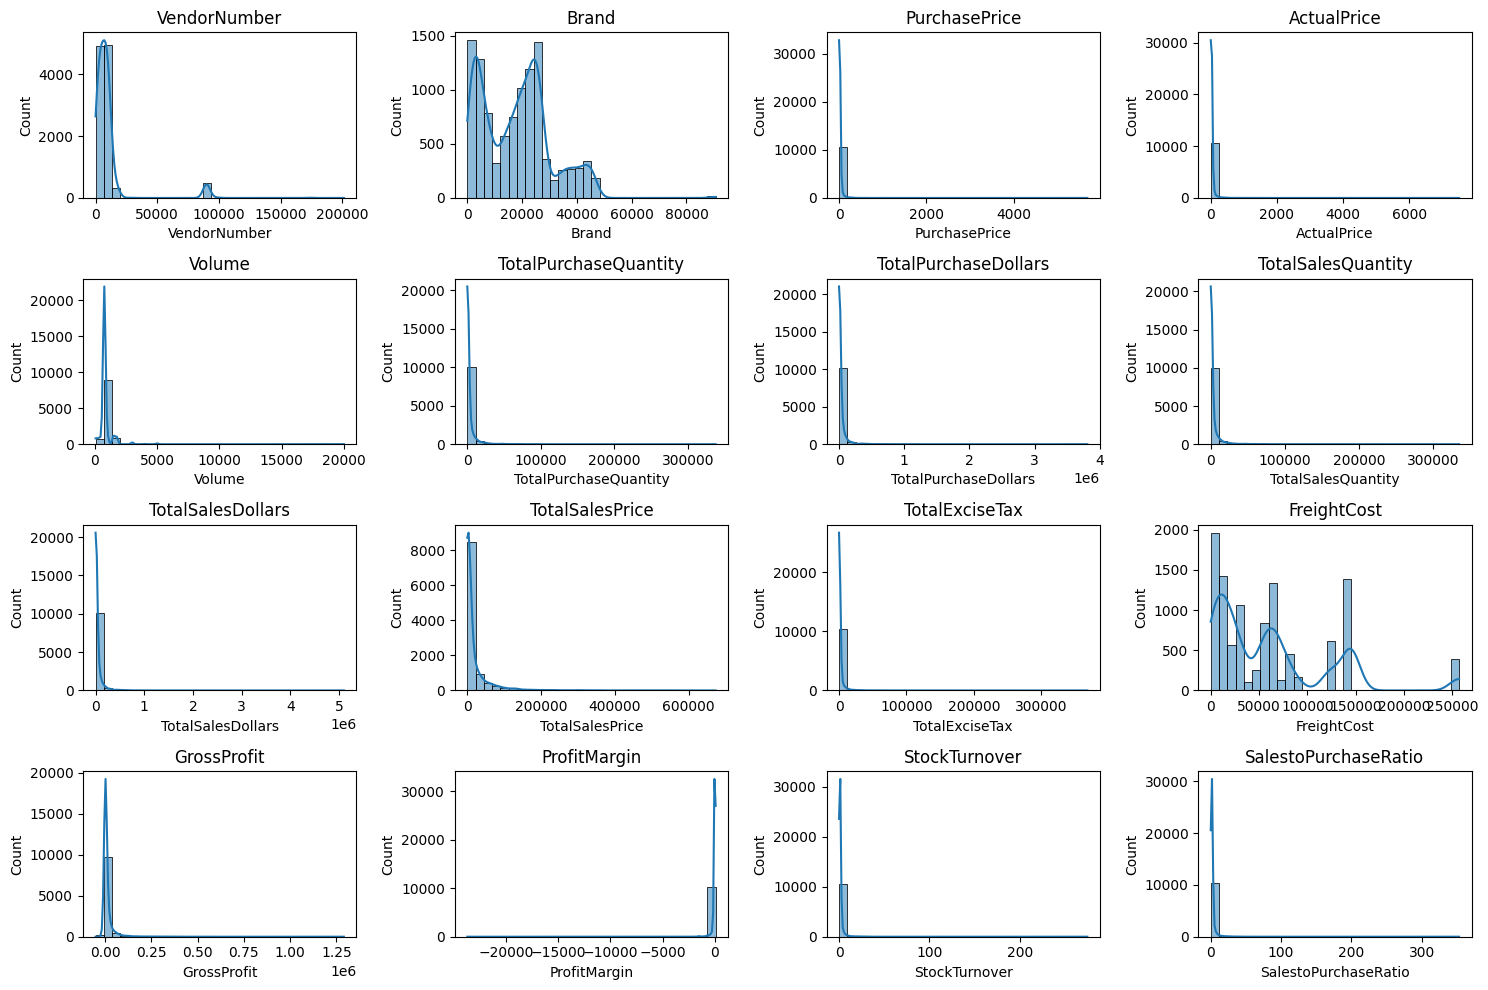

In [43]:
# 1. Extract numerical feature names
# We select only columns with numeric types (int, float) to avoid errors during plotting
numerical_col = df.select_dtypes(include=np.number).columns

# 2. Initialize the plotting area
# figsize sets the overall width (15) and height (10) of the dashboard in inches
plt.figure(figsize=(15,10))

# 3. Iterate through each numerical column to create individual plots
for i, col in enumerate(numerical_col):
    
    # Define a grid of 4 rows and 4 columns
    # 'i+1' represents the current position in the grid (starts from 1)
    plt.subplot(4, 4, i+1)
    
    # Create a histogram with a Kernel Density Estimate (KDE) line
    # kde=True overlays a smooth curve to visualize the probability distribution
    # bins=30 divides the data into 30 intervals for better granularity
    sns.histplot(df[col], kde=True, bins=30)
    
    # Set the subplot title as the column name for identification
    plt.title(col)

# 4. Automatic spacing adjustment
# Ensures that titles and axis labels do not overlap between subplots
plt.tight_layout()

# 5. Render the plots
plt.show()

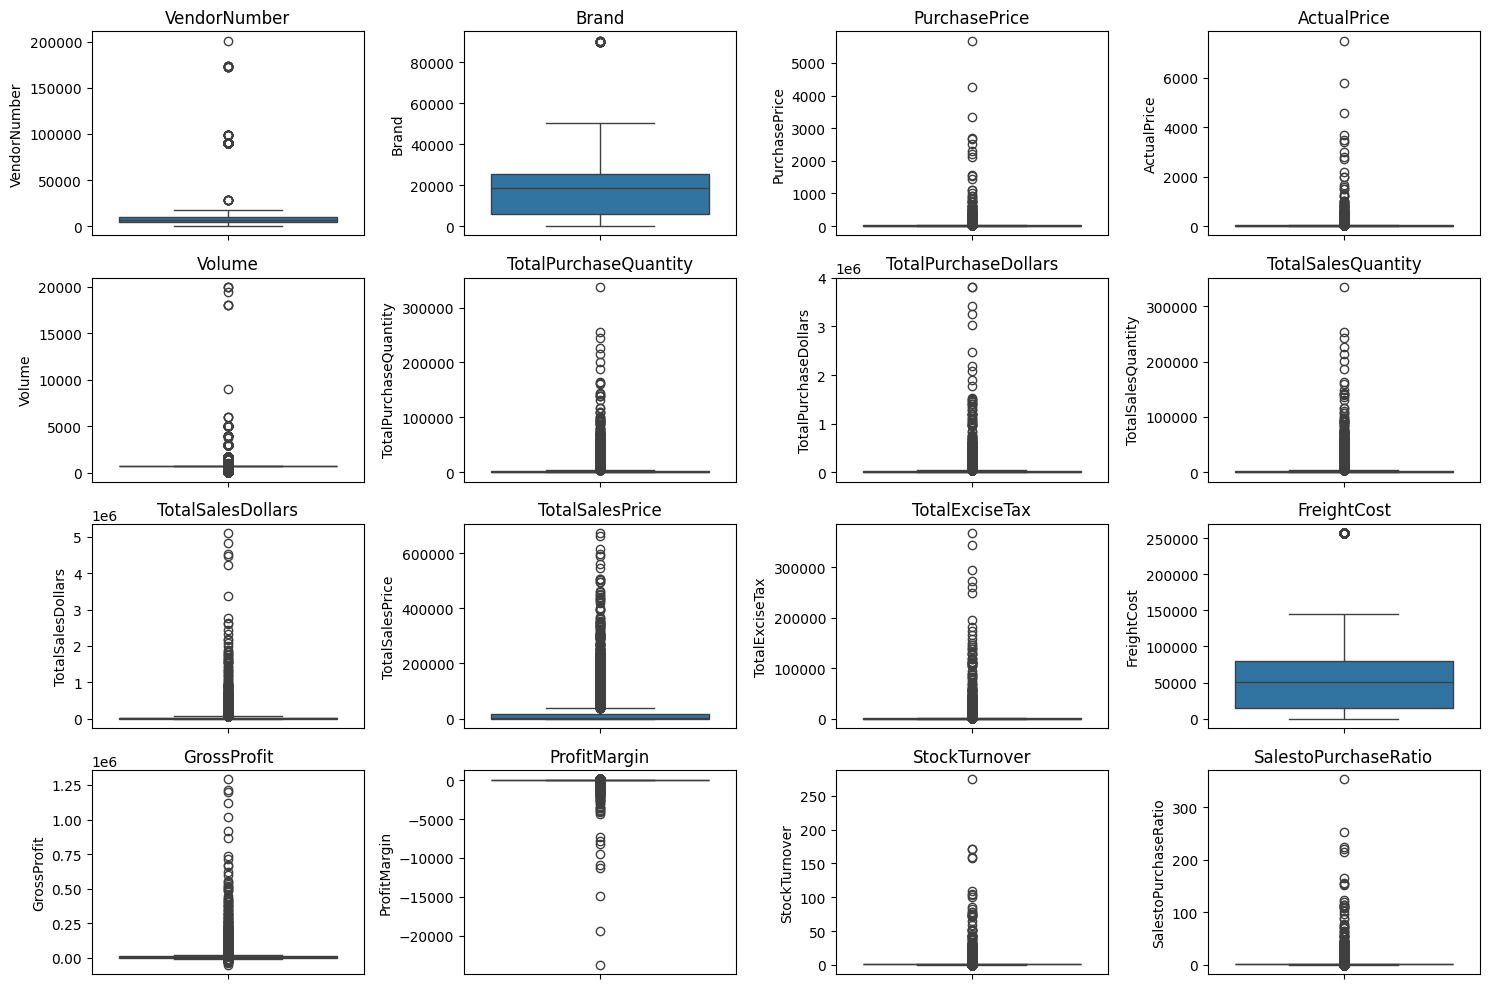

In [44]:
# 1. Identify all numerical features
# Selects columns with integer or float types for statistical visualization
numerical_col = df.select_dtypes(include=np.number).columns

# 2. Set up the visualization grid
# A larger figure size ensures that the boxplots are legible
plt.figure(figsize=(15,10))

# 3. Loop through columns to generate Boxplots
for i, col in enumerate(numerical_col):
    
    # Create a subplot in a 4x4 grid
    plt.subplot(4, 4, i+1)
    
    # Generate a vertical Boxplot
    # This visualizes the Five-Number Summary: Min, Q1, Median, Q3, and Max
    sns.boxplot(y=df[col])
    
    # Add the column name as a title for clarity
    plt.title(col)

# 4. Refine layout
# Adjusts subplots so that labels and titles are clearly separated
plt.tight_layout()

# 5. Display the final set of plots
plt.show()

### **Summary Statistics Insights:**

**Negative & Zero Values:**

- Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price..
- Profit Margin: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.
- Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.

**Outliers Indicated by High Standard Deviations:**

- Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.
- Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.
- Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock..

### 4.2. Data Filtering

In [45]:
# 1. Execute SQL query and load results into a Pandas DataFrame
# We use pd.read_sql to combine SQL's filtering power with Pandas' analytical tools
df = pd.read_sql("""
    SELECT *
    FROM vandor_sales_summary
    WHERE GrossProfit > 0        -- Filter 1: Removes loss-making transactions or data errors
    AND ProfitMargin > 0         -- Filter 2: Ensures only profitable records are analyzed
    AND TotalSalesQuantity > 0   -- Filter 3: Excludes returns, cancelled orders, or zero-sale entries
""", conn) # 'conn' is your active database connection object


In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,8564.0,10107.074965,17635.714818,2.000000,3664.000000,7153.000000,9552.000000,2.013590e+05
Brand,8564.0,17614.670131,12946.130933,58.000000,5375.750000,17606.000000,24935.250000,9.063100e+04
PurchasePrice,8564.0,21.780897,81.189624,0.360000,6.660000,10.060000,17.850000,3.352930e+03
ActualPrice,8564.0,32.297467,112.420744,0.490000,9.990000,14.990000,25.990000,4.559990e+03
Volume,8564.0,864.332263,724.240079,50.000000,750.000000,750.000000,750.000000,2.000000e+04
TotalPurchaseQuantity,8564.0,3772.008991,12276.960631,1.000000,42.000000,431.000000,2666.750000,3.376600e+05
TotalPurchaseDollars,8564.0,35887.253324,136722.999153,0.710000,546.187500,5018.400000,26610.177500,3.811252e+06
TotalSalesQuantity,8564.0,3748.983419,12125.696083,1.000000,62.000000,490.500000,2675.000000,3.349390e+05
TotalSalesDollars,8564.0,51542.278077,186071.489729,1.980000,1355.580000,8483.780000,40622.112500,5.101920e+06
TotalSalesPrice,8564.0,22759.270732,49305.274018,0.990000,584.790000,4549.755000,22595.252500,6.728193e+05


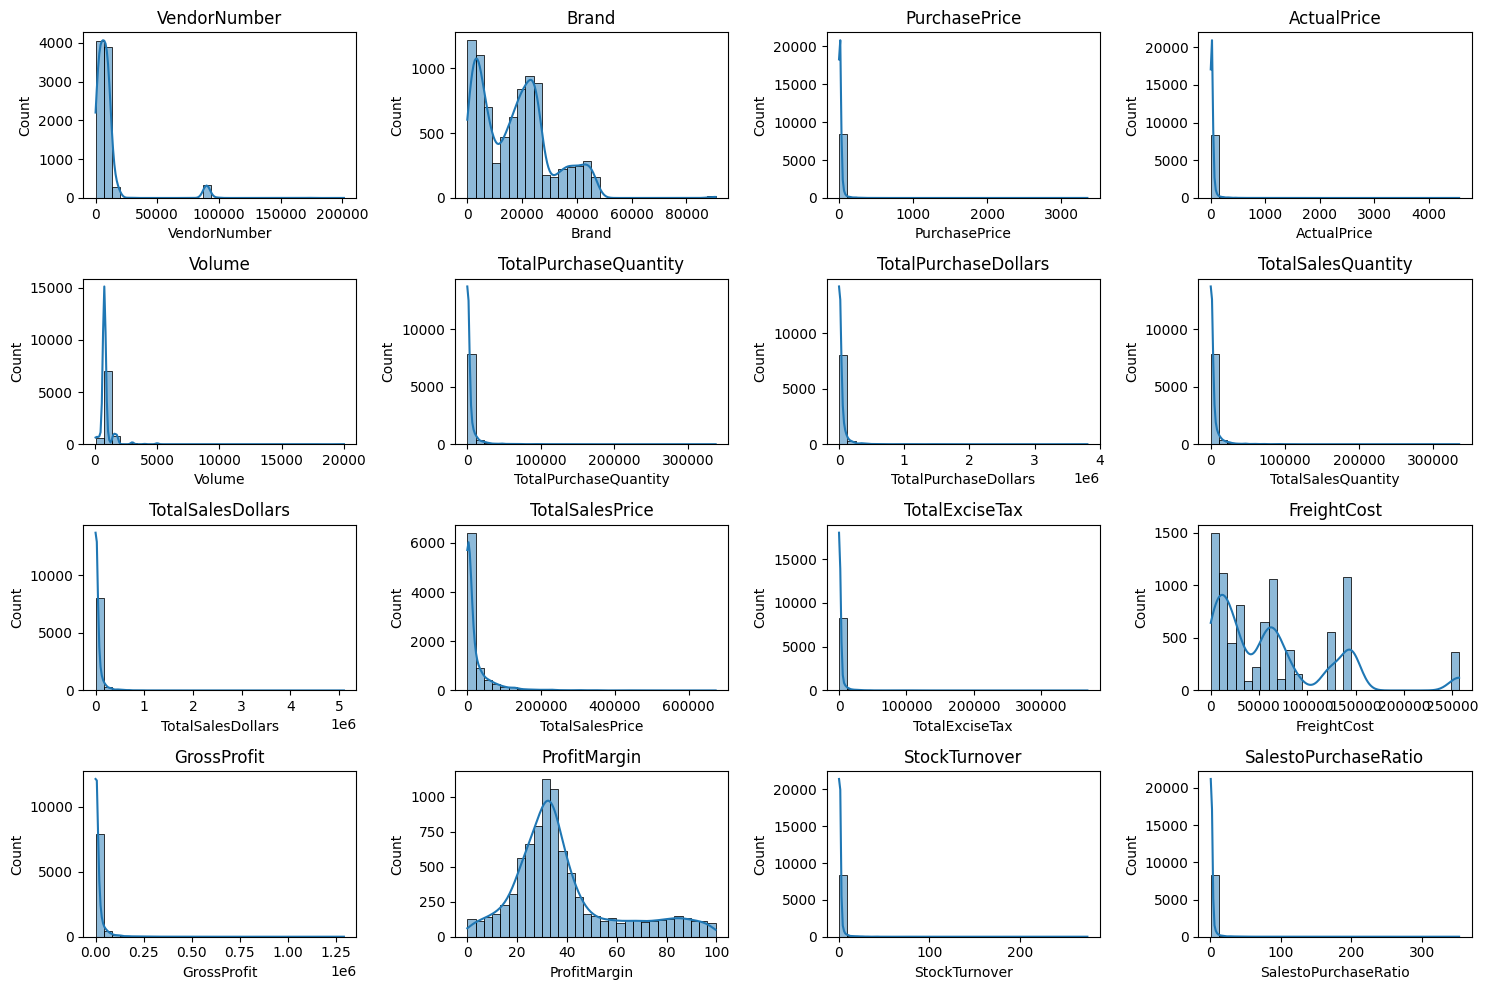

In [47]:
# checking the plots after the alteration
numerical_col = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_col):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

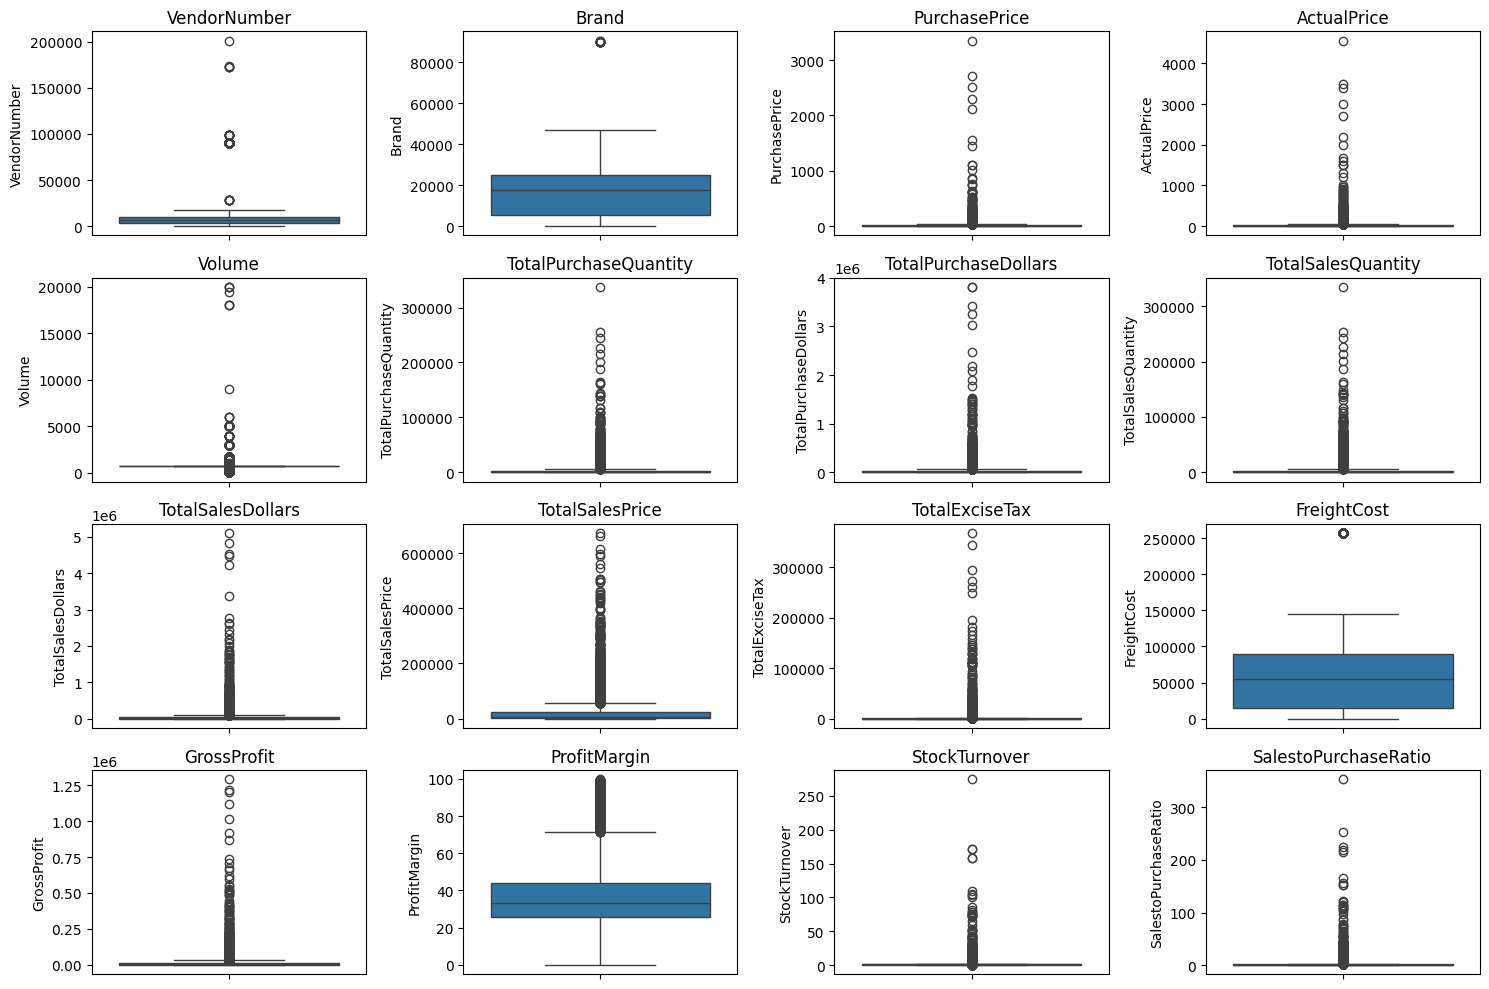

In [48]:
# checking the plots after the alteration
numerical_col = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_col):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### 4.3. Distributions and Correlations

### 4.3.1. Correlation Insights

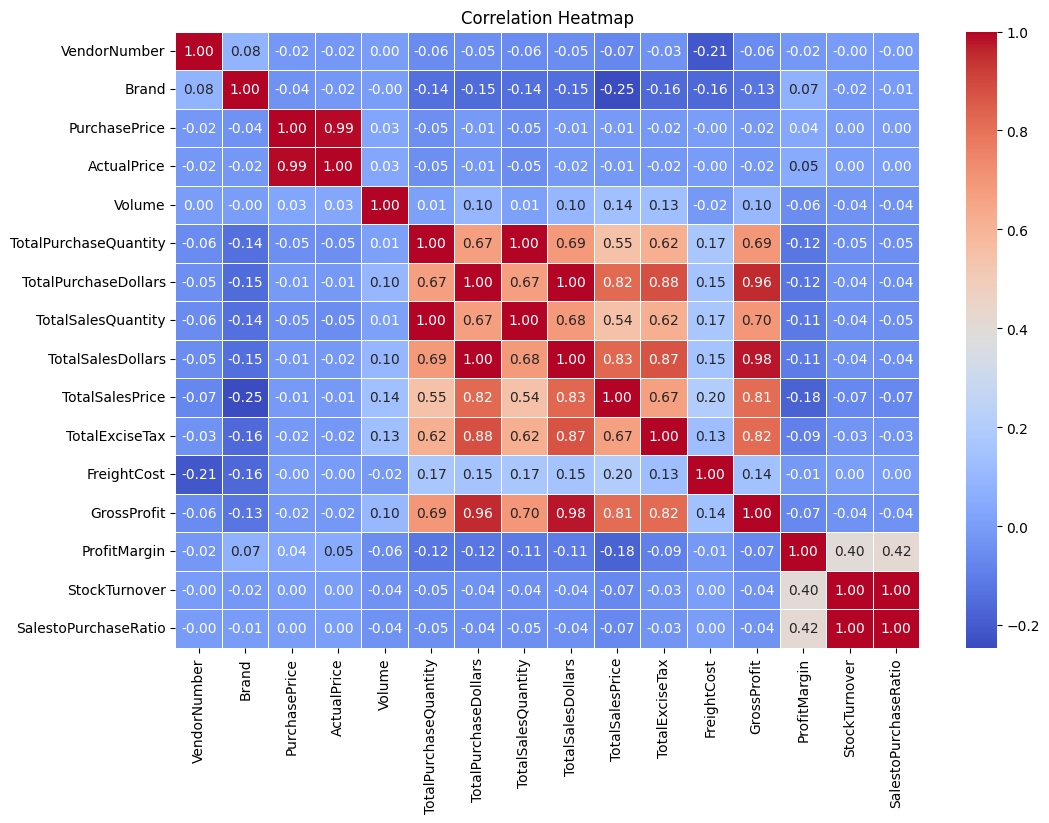

In [89]:
# 1. Initialize the figure size
# A larger size (12x8) ensures the correlation numbers (annotations) are readable
plt.figure(figsize=(12,8))

# 2. Calculate the Pearson Correlation Coefficient
# This creates a matrix showing how every numerical column correlates with every other column
# Values range from -1 (perfect negative) to +1 (perfect positive)
correlation_matrix = df[numerical_col].corr()

# 3. Generate the Heatmap
# annot=True: Displays the actual correlation values inside the cells
# fmt=".2f": Rounds the numbers to two decimal places for clarity
# cmap="coolwarm": Uses a color scale where Blue is negative, White is neutral, and Red is positive
# linewidth=0.5: Adds a small gap between cells to make the grid distinct
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidth=0.5)

# 4. Finalize the plot
plt.title("Correlation Heatmap")
plt.show()

- PurchasePrice has weak correlations with TotalSalesDollars (-0.012) and GrossProfit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.
- Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.
- Negative correlation between profit margin & total sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.
- StockTurnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.

### 4.3.2. Vendors and Brands Analysis

### 4.3.2.1. Brands Analysis

Identify Brands that needs Promotional or Pricing Adjustments which exhibit lower sales performance but higher profit margins.

In [51]:
df.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnover', 'SalestoPurchaseRatio'],
      dtype='object')

In [52]:
# 1. Group the data by product 'Description'
# 2. Apply different aggregate functions to specific columns:
#    - 'TotalSalesDollars': Summed to show total revenue per brand
#    - 'ProfitMargin': Averaged to show the typical profitability of that brand
# 3. reset_index(): Converts the result from a GroupBy object back into a clean Pandas DataFrame
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars': 'sum',
    'ProfitMargin': 'mean'
}).reset_index()

In [53]:
# 1. Identify the 15th percentile of Total Sales
# Brands with sales below this value are in the bottom 15% of your portfolio
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)

# 2. Identify the 85th percentile of Profit Margin
# Brands with margins above this value are in the top 15% of your most profitable brands
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

In [54]:
low_sales_threshold

np.float64(560.299)

In [55]:
high_margin_threshold

np.float64(64.97017552750113)

In [56]:
# 1. Apply multiple logical filters to the brand_performance data:
#    - Condition A: Sales must be in the bottom 15% (<= low_sales_threshold)
#    - Condition B: Profit Margin must be in the top 15% (>= high_margin_threshold)
target_brand = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]

# 2. Output the results
print("Brands with low sales but with high profit margin:")

# 3. Sort and Display
# We sort by 'TotalSalesDollars' to see the smallest entries first
display(target_brand.sort_values('TotalSalesDollars'))

Brands with low sales but with high profit margin:


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


In [57]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] <10000] #for better visualization

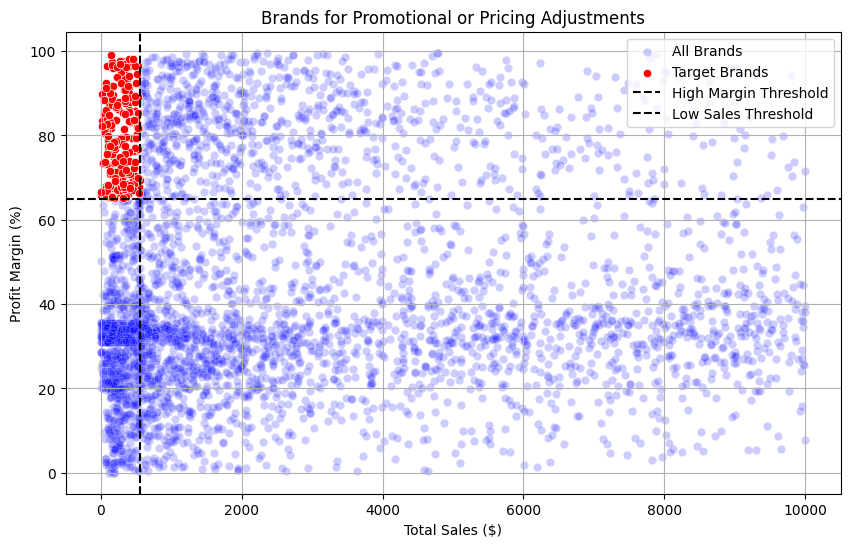

In [58]:
# 1. Initialize figure size
plt.figure(figsize=(10,6))

# 2. Plot the background data (All Brands)
# alpha=0.2 makes these points semi-transparent so they don't distract from the targets
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', 
                color='blue', label="All Brands", alpha=0.2)

# 3. Overlay the "Hidden Gems" (Target Brands)
# These are plotted in Red to make them immediately stand out for stakeholders
sns.scatterplot(data=target_brand, x='TotalSalesDollars', y='ProfitMargin', 
                color='red', label="Target Brands")

# 4. Add Reference Lines (Benchmarks)
# These dashed lines visually represent the 85th and 15th percentile thresholds
plt.axhline(high_margin_threshold, linestyle="--", color="black", label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle="--", color="black", label="Low Sales Threshold")

# 5. Add Labels and Formatting
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True) # Adds a grid for easier coordinate estimation

# 6. Render plot
plt.show()

### 4.3.2.2. Top 10 Vendors and Brands

### 4.3.2.2.1 Top 10 vendors and brands in terms of Frequency

Which vendors and brands demonstrate the highest sales performance?

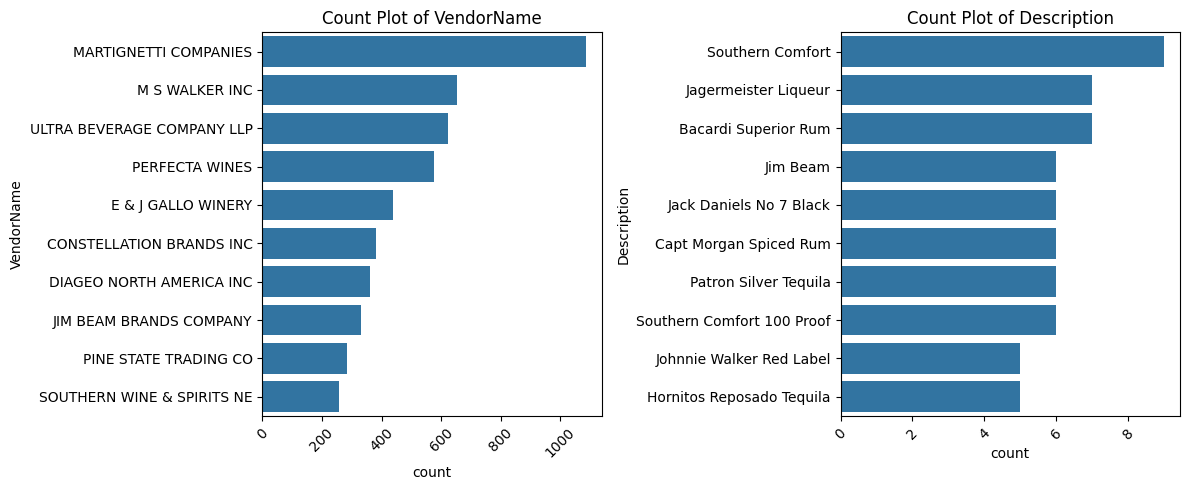

In [49]:
# 1. Define the categorical features for analysis
# Selecting 'VendorName' and 'Description' to understand market share and variety
categorical_cols = ['VendorName', 'Description']

# 2. Initialize the visualization layout
# Set a wide figure (12x5) to accommodate side-by-side comparison
plt.figure(figsize=(12,5))

# 3. Iterate through categories to create Count Plots
for i, col in enumerate(categorical_cols):
    
    # Create a 1-row, 2-column grid
    plt.subplot(1, 2, i+1)
    
    # Generate the count plot for the top 10 most frequent items
    # order=... ensures the bars are sorted from highest to lowest frequency
    # [:10] limits the plot to the Top 10 items to prevent overcrowding
    sns.countplot(df[col], order=df[col].value_counts().index[:10])
    
    # Add a dynamic title and rotate x-labels for better readability
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45) # Recommended to prevent overlapping vendor names

# 4. Finalize and show
plt.tight_layout()
plt.show()

### 4.3.2.2.2 Top 10 vendors and brands in terms of Sales

In [59]:
# A helper function to convert large numbers into abbreviated string formats (K, M)
def format_dollars(value):
    # Check if the value is in the Millions
    if value >= 1_000_000:
        return f"{value / 1_000_000 :.2f}M"
    
    # Check if the value is in the Thousands
    elif value >= 1_000:
        return f"{value / 1_000 :.2f}K"
    
    # If the value is small, return it as a plain string
    else:
        return str(value)

In [60]:
# extracting the top 10 vendors and brands in terms of TotalSalesDollars
top_vendors = df.groupby("VendorName")['TotalSalesDollars'].sum().nlargest(10)
top_brands = df.groupby("Brand")["TotalSalesDollars"].sum().nlargest(10)

In [61]:
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      67990099.42
MARTIGNETTI COMPANIES         39330359.36
PERNOD RICARD USA             32063196.19
JIM BEAM BRANDS COMPANY       31423020.46
BACARDI USA INC               24854817.14
CONSTELLATION BRANDS INC      24218745.65
E & J GALLO WINERY            18399899.46
BROWN-FORMAN CORP             18247230.65
ULTRA BEVERAGE COMPANY LLP    16502544.31
M S WALKER INC                14706458.51
Name: TotalSalesDollars, dtype: float64

In [62]:
top_brands

Brand
1233    5101919.51
3405    4819073.49
8068    4538120.60
4261    4475972.88
3545    4223107.62
3858    3383912.40
2589    2773367.73
3489    2640491.19
3102    2592041.35
1376    2435393.39
Name: TotalSalesDollars, dtype: float64

In [63]:
# applying the predefined function
top_brands.apply(lambda x: format_dollars(x))

Brand
1233    5.10M
3405    4.82M
8068    4.54M
4261    4.48M
3545    4.22M
3858    3.38M
2589    2.77M
3489    2.64M
3102    2.59M
1376    2.44M
Name: TotalSalesDollars, dtype: object

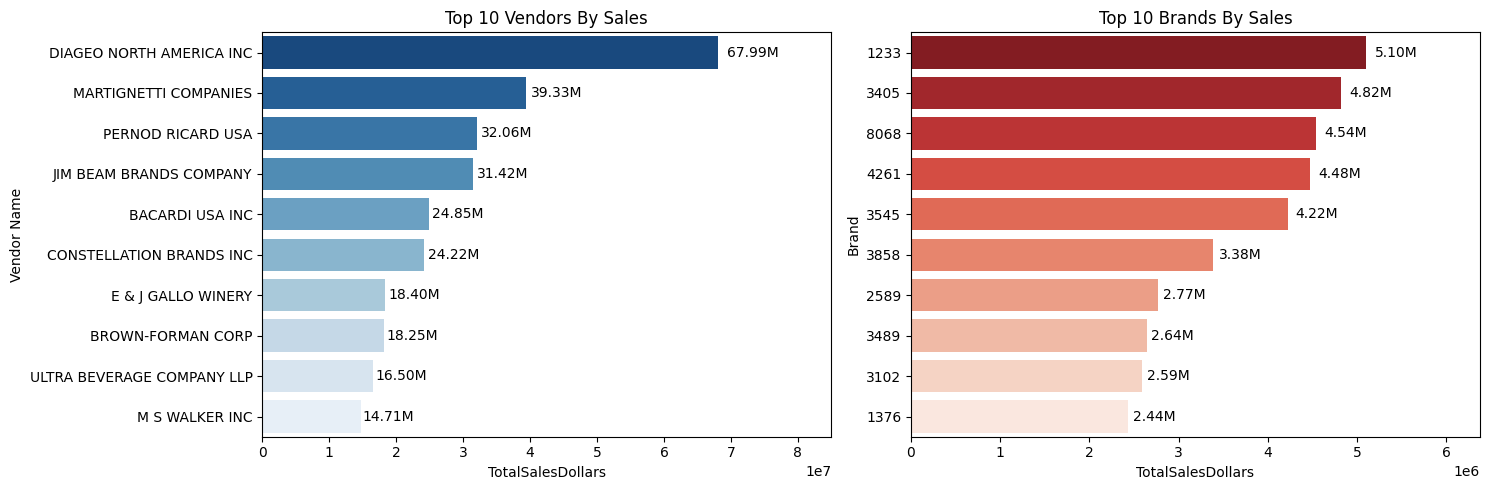

In [64]:
# 1. Set up a wide canvas for two side-by-side plots
plt.figure(figsize=(15,5))

# --- LEFT PLOT: Top Vendors ---
plt.subplot(1,2,1)
# Create a horizontal bar chart for the top 10 vendors
# 'Blues_r' provides a professional blue gradient (reversed)
ax1 = sns.barplot(y=top_vendors.index, hue=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors By Sales")

# Add data labels to the end of each bar using the custom format_dollars function
for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02), # Padding from end of bar
             bar.get_y() + bar.get_height()/2,          # Vertically centered in bar
             format_dollars(bar.get_width()),           # Human-readable label (e.g., 50.00K)
             ha='left', va='center', fontsize=10, color='black')

# Extend the X-axis limit to ensure labels aren't cut off
ax1.set_xlim(0, top_vendors.values.max() * 1.25)
ax1.set_ylabel("Vendor Name")
ax1.set_xlabel("TotalSalesDollars")

# --- RIGHT PLOT: Top Brands ---
plt.subplot(1,2,2)
# Create a horizontal bar chart for the top 10 brands
# 'Reds_r' provides a distinct red gradient to differentiate from the vendor plot
ax2 = sns.barplot(y=top_brands.index.astype(str), hue=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands By Sales")

# Add data labels to the end of each bar
for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height()/2,
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')

ax2.set_xlim(0, top_brands.values.max() * 1.25)
ax2.set_xlabel("TotalSalesDollars")

# 2. Finalize layout to prevent overlapping
plt.tight_layout()
plt.show()

### 4.3.2.2.3 Vendors Purchase Contribution

Which vendors contribute the most to total purchase dollars?

In [65]:
df.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnover', 'SalestoPurchaseRatio'],
      dtype='object')

In [66]:
# 1. Group the data by 'VendorName' to consolidate all transactions per supplier
# 2. Use .agg() to calculate three key business metrics simultaneously:
#    - 'TotalPurchaseDollars': Summed to show total investment in stock from that vendor
#    - 'GrossProfit': Summed to show the total earnings after cost per vendor
#    - 'TotalSalesDollars': Summed to show the total revenue generated by that vendor
# 3. reset_index(): Flattens the result back into a standard DataFrame for further analysis
vendor_performance = df.groupby("VendorName").agg({
    "TotalPurchaseDollars":"sum",
    "GrossProfit" : "sum",
    "TotalSalesDollars": "sum"
}).reset_index()

In [67]:
# 1. Calculate the 'Purchase_Contribution%' for each vendor:
#    - We take the 'TotalPurchaseDollars' for a specific vendor
#    - Divide it by the .sum() of the entire column (the total spend on all vendors)
#    - Multiply by 100 to convert the decimal into a percentage format
vendor_performance['Purchase_Contribution%'] = (
    vendor_performance['TotalPurchaseDollars'] / 
    vendor_performance['TotalPurchaseDollars'].sum() * 100
)

In [68]:
# 1. Sort the DataFrame by 'Purchase_Contribution%' in descending order (highest to lowest)
# 2. Apply round() to the entire DataFrame to limit all numeric values to 2 decimal places
# 3. Overwrite the variable with this clean, ordered version
vendor_performance = round(
    vendor_performance.sort_values('Purchase_Contribution%', ascending=False), 
    2
)

In [69]:
# 1. Create a deep copy of the top 10 vendors to avoid 'SettingWithCopy' warnings
top_vendors = vendor_performance.head(10).copy()

# 2. Apply your custom 'format_dollars' function to clean up the financial columns
# This converts raw numbers (e.g., 25700.0) into abbreviated strings (e.g., '25.70K')
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

# 3. Display the final formatted table
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [70]:
# 1. Calculate the Cumulative Sum (running total) of the 'Purchase_Contribution%'
# Since 'top_vendors' is already sorted from highest to lowest, 
# this shows the combined market share as you add each vendor down the list.
top_vendors['Cumulative_Contribution%'] = top_vendors['Purchase_Contribution%'].cumsum()

# 2. Display the updated table
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,Purchase_Contribution%,Cumulative_Contribution%
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


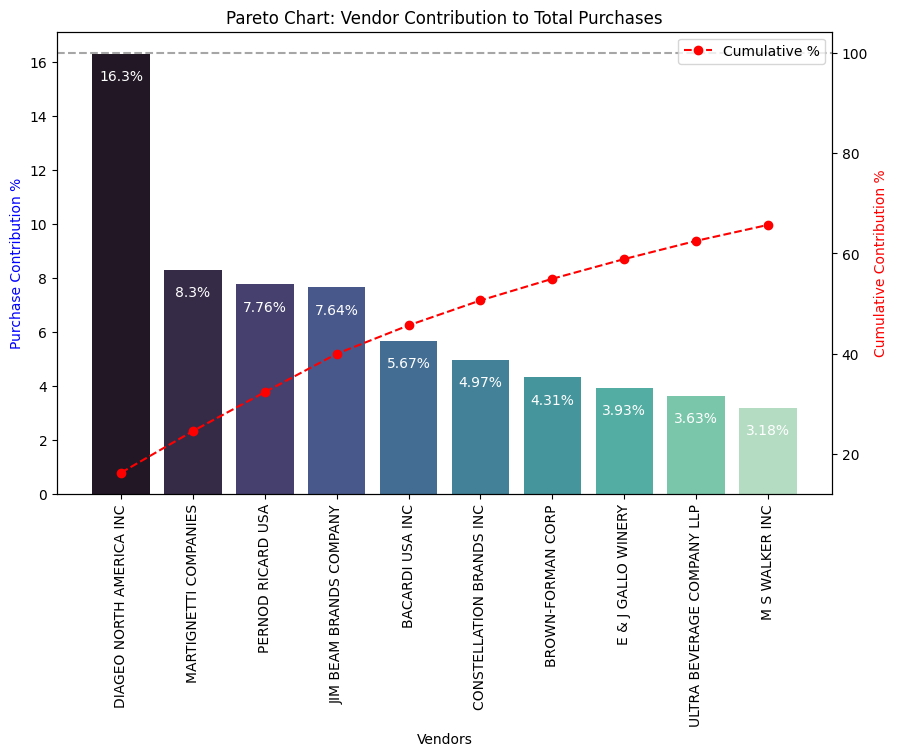

In [71]:
# 1. Create a figure with a dual Y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# 2. Draw the Bar Chart (Individual Contributions)
# 'mako' palette provides a professional dark-to-light teal gradient
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['Purchase_Contribution%'], 
            hue=top_vendors['VendorName'], palette="mako", ax=ax1)

# Add data labels inside/on top of the bars for immediate readability
for i, value in enumerate(top_vendors['Purchase_Contribution%']):
    ax1.text(i, value - 1, f'{value}%', ha='center', fontsize=10, color='white')

# 3. Create a Second Y-Axis for the Cumulative Line
ax2 = ax1.twinx()
# The 'red' dashed line tracks the running total of the percentages
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], 
         color='red', marker='o', linestyle='dashed', label='Cumulative %')

# 4. Formatting and Labeling
ax1.set_xticks(range(len(top_vendors['VendorName'])))
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90) # Rotate names for clarity
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

# 5. Add a 100% threshold line to show where the total is capped
ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

### How much of total procurement is dependent on the top vendors?

In [72]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['Purchase_Contribution%'].sum(),2)} %")

Total Purchase Contribution of top 10 vendors is 65.69 %


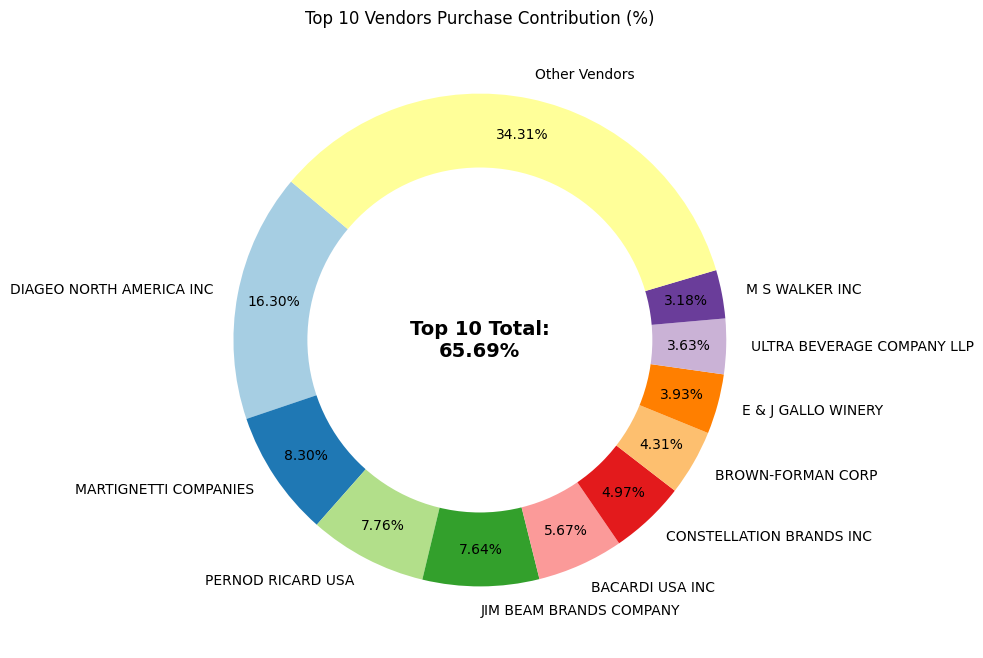

In [73]:
# 1. Prepare data for the pie/donut chart
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['Purchase_Contribution%'].values)

# 2. Calculate the 'Long Tail' (All vendors not in the Top 10)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# 3. Add the 'Other' category to round out the 100%
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# 4. Initialize the plot
fig, ax = plt.subplots(figsize=(8,8))
# Draw the pie chart with a starting angle for better aesthetics
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.2f%%',
                                 startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# 5. Transform the Pie into a Donut
# Create a white circle and place it in the center of the pie
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 6. Add a Central Summary Label
# Displays the combined strength of the Top 10 in the hole of the donut
plt.text(0,0, f"Top 10 Total:\n{total_contribution:.2f}%", 
         fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendors Purchase Contribution (%)")
plt.show()

### Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [74]:
df.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnover', 'SalestoPurchaseRatio'],
      dtype='object')

In [75]:
# Calculate the average cost per unit for each record
# Formula: Total Spend / Number of Items Purchased
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [76]:
# 1. Divide 'TotalPurchaseQuantity' into 3 equal-sized buckets (Quantiles)
# - Small: The bottom 33% of orders by quantity
# - Medium: The middle 33% of orders
# - Large: The top 33% of orders
# 2. Assign labels to these buckets for better readability in analysis
df['OrderSize'] = pd.qcut(df["TotalPurchaseQuantity"], q=3, labels=["Small", "Medium", "Large"])

In [91]:
# 1. Group the data by the newly created 'OrderSize' categories
# 2. observed=False: Ensures all categories (Small, Medium, Large) are shown even if one is empty
# 3. [['UnitPurchasePrice']]: Selects the unit cost for analysis
# 4. .mean(): Calculates the average cost for each order size group
df.groupby('OrderSize', observed=False)[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.068186
Medium,15.486414
Large,10.777625


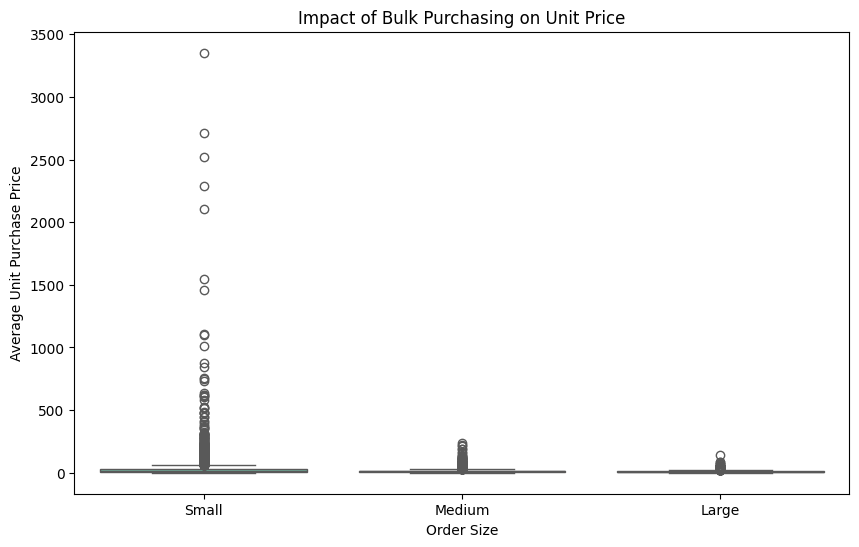

In [78]:
# 1. Set the dimensions for a clear visualization
plt.figure(figsize=(10, 6))

# 2. Generate the Boxplot
# - x="OrderSize": Categorizes the data into Small, Medium, and Large
# - y="UnitPurchasePrice": Shows the distribution of costs
# - hue="OrderSize": Adds distinct colors for each group for better visual separation
# - palette="Set2": Uses a professional, soft color scheme
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", hue="OrderSize", palette="Set2")

# 3. Add descriptive labels and title
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")

# 4. Render the plot
plt.show()

- Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
- The price difference between Small and Large orders is substantial (~72% reduction in unit cost)
- This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.

Which vendors have low inventory turnover, indicating excess stock and slow-moving products?

In [79]:
df.columns

Index(['VendorNumber', 'VendorName', 'Brand', 'Description', 'PurchasePrice',
       'ActualPrice', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'TotalSalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnover', 'SalestoPurchaseRatio',
       'UnitPurchasePrice', 'OrderSize'],
      dtype='object')

In [80]:
# 1. Filter for efficiency issues: Keep only records where StockTurnover is less than 1 
#    (Meaning the item hasn't sold its full inventory even once)
# 2. Group by 'VendorName' to consolidate these problematic records per supplier
# 3. Calculate the .mean(): Find the average turnover rate for these slow items
# 4. Sort and limit: Show the 10 vendors with the absolute lowest (worst) turnover rates
df[df['StockTurnover'] < 1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover', ascending=True).head(10)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
SMOKY QUARTZ DISTILLERY LLC,0.783835
TAMWORTH DISTILLING,0.797078
THE IMPORTED GRAPE LLC,0.807569


How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [81]:
# 1. Calculate the value of remaining stock for each record
# Formula: (Items Bought - Items Sold) * Cost Price per Item
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]

# 2. Sum the entire column and format it using your custom 'format_dollars' function
# This provides a high-level KPI of your total "Unsold Capital"
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital: 2.71M


In [82]:
# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)


,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


### **5. Data Refinement for Insights**

### 5.1. Evaluating the confidence intervals

What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors.

In [83]:
# 1. Identify the 75th percentile (Top Quartile)
# This represents the sales figure that only 25% of your records managed to exceed.
# Anything above this is considered "High Performance."
top_threshold = df["TotalSalesDollars"].quantile(0.75)

# 2. Identify the 25th percentile (Bottom Quartile)
# This represents the sales figure where 25% of your records fell below.
# Anything below this is considered "Low Performance."
low_threshold = df["TotalSalesDollars"].quantile(0.25)

In [84]:
# 1. Isolate the "Top Performers" (High Volume)
# - Filter for records in the top 25% of sales
# - Select only the 'ProfitMargin' column
# - .dropna() ensures that missing data doesn't crash the statistical test
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()

# 2. Isolate the "Low Performers" (Low Volume)
# - Filter for records in the bottom 25% of sales
# - Select the 'ProfitMargin' column for comparison
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [85]:
def confidence_interval(data, confidence=0.95):
    # 1. Calculate the Point Estimate (The sample mean)
    mean_val = np.mean(data)
    
    # 2. Calculate the Standard Error (SE)
    # ddof=1 is used for sample standard deviation
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    
    # 3. Find the T-Critical Value
    # This adjusts based on the confidence level (e.g., 95%) and degrees of freedom
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    
    # 4. Calculate the Margin of Error
    margin_of_error = t_critical * std_err
    
    # Returns: (Mean, Lower Bound, Upper Bound)
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (30.74, 31.61), Mean: 31.18
Low Vendors 95% CI: (40.50, 42.64), Mean: 41.57


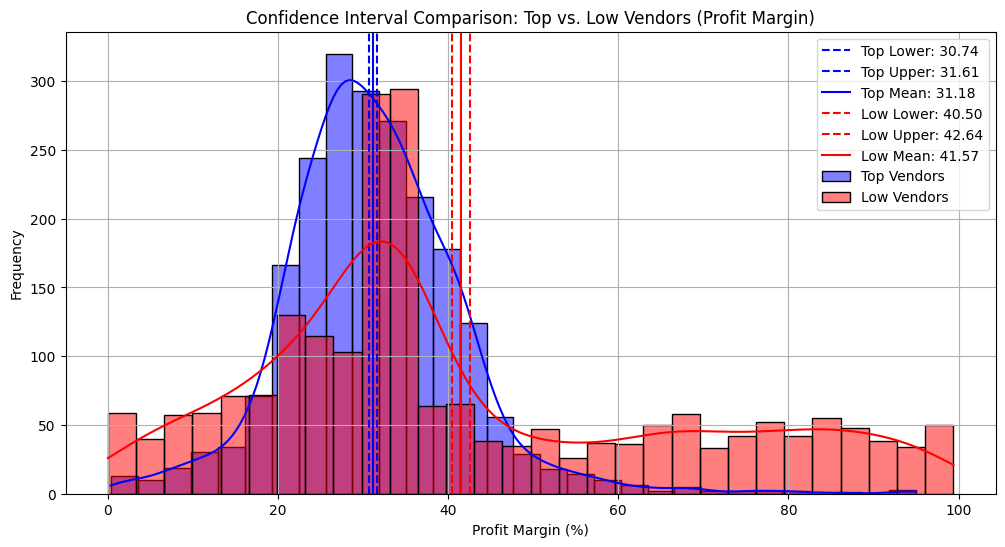

In [86]:
# 1. Calculate the 95% Confidence Intervals for both segments
# This gives us the 'Mean' and the 'Lower/Upper bounds' of our certainty
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

# 2. Output the statistical summary to the console
print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

# 3. Initialize the visualization
plt.figure(figsize=(12, 6))

# --- PLOT TOP VENDORS (Blue) ---
# kde=True overlays a smooth curve showing the probability density
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# --- PLOT LOW VENDORS (Red) ---
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# 4. Finalize and Format
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

- The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%).
- This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.
- For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies.
- For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.

### Question:
**Is there a significant difference in profit margins between top-performing and low-performing vendors?**

### 5.2. Hypotheses Testing
*   **$H_0$ (Null Hypothesis):** There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
*   **$H_1$ (Alternative Hypothesis):** The mean profit margins of top-performing and low-performing vendors are significantly different.

In [87]:
# 1. Establish performance tiers (Top 25% vs Bottom 25%)
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

# 2. Extract profit margins for both groups, removing null values for calculation accuracy
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# 3. Perform the Independent Two-Sample T-Test
# equal_var=False: Applies Welch’s T-test, which is safer as it doesn't assume 
# both groups have the same variance (common in real-world sales data).
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# 4. Interpret the Results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

# The standard Alpha level is 0.05 (5% risk of being wrong)
if p_value < 0.05:
    print("Reject H0: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H0: No significant difference in profit margins.")


T-Statistic: -17.6695, P-Value: 0.0000
Reject H0: There is a significant difference in profit margins between top and low-performing vendors.
